<a href="https://colab.research.google.com/github/adir-hil/HeteroGraphs-for-OC-logs/blob/main/R12_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [1]:
from IPython.display import clear_output

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install Pympler
!pip install importlib
clear_output()

# Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%cd gdrive/MyDrive/ocel

import pandas as pd
# import utility_funcs_r1 as ufr1
import utility_funcs_r1b as ufr1b
import torch

Mounted at /content/gdrive
/content/gdrive/MyDrive/ocel


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:84: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.s

In [ ]:
# import utility_funcs_r1 as ufr1
import importlib
importlib.reload(ufr1)

NameError: name 'ufr1' is not defined

# PreProcessing

In [84]:
new_df_lc = pd.read_csv('/content/gdrive/MyDrive/ocel/with_lables.csv')
new_df_lc['LIFECYCLE_BATCH'] = new_df_lc['LIFECYCLE_BATCH'].astype(str)
new_df_lc['TIMESTAMP'] = pd.to_datetime(new_df_lc['TIMESTAMP'])
new_df_lc.drop("Unnamed: 0",axis=1,inplace =True)
new_df_lc.drop("Unnamed: 0.1",axis=1,inplace =True)

# Get the order of batches based on the first timestamp of each batch
batch_order = new_df_lc.groupby('LIFECYCLE_BATCH')['TIMESTAMP'].min().sort_values().index
# Reindex the dataframe based on the batch order
new_df_lc = new_df_lc.set_index('LIFECYCLE_BATCH').loc[batch_order].reset_index()

# Calculate the first timestamp in the dataframe
first_timestamp = new_df_lc['TIMESTAMP'].min()

# Create a new column called 'DAYS_FROM_FIRST_EVENT'
new_df_lc['DAYS_FROM_FIRST_EVENT'] = (new_df_lc['TIMESTAMP'] - first_timestamp).dt.days

<ipython-input-84-cf89208f6960>:1: DtypeWarning: Columns (3,9,23) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df_lc = pd.read_csv('/content/gdrive/MyDrive/ocel/with_lables.csv')


In [85]:
features_cols = ['NEW_EVENT_ID','PRODUCT', 'MATERIAL', 'LIFECYCLE_BATCH','LOT','LOCATION',
        'AREA','SITE','PMX_USER','PMX_ORDER','ORDER_STEP','TU']
nodes_types = ['event','product', 'material', 'batch','lot','location',
               'area','site','employee','order','order_step','tu']
col_mapping = {node_type: col for node_type, col in zip(nodes_types, features_cols)}
hours_cols = [f"hour_{i}" for i in range(24)]
tertile_cols = ['tertile_12am-8am', 'tertile_8am-4pm', 'tertile_4pm-12am']

In [86]:
node_features_dict = dict(ufr1b.generate_node_features(new_df_lc, col_mapping,
                                                      'NEW_EVENT_ID','ACTIVITY',
                                                      hours_cols,tertile_cols,
                                                      'grouped_time_since_first_day',
                                                      'DAYS_FROM_LC_START')
)

Number of unique events processed: 271032
Shape of activity one-hot encoded features: (271032, 9)
Shape of hour features: (271032, 24)
Shape of tertile features: (271032, 3)
Shape of time features: (271032, 2)
Shape of full event feature matrix: (271032, 38)


# Creating (PyG) Heterodata object

Nodes

In [114]:
data = ufr1b.create_heterodata_nodes(node_features_dict)

Edges

### Required Edges -R1:

In [93]:
edge_types_R1 = [
#-------------Hierarchical object relationships-------------------------
   {
        'edge_type': ('area', 'O2O', 'site'),
        'col_src': 'AREA',
        'col_dst': 'SITE',
        'edge_class': 'O2O',
        'directed':False
    },
   {
        'edge_type': ('location', 'O2O', 'area'),
        'col_src': 'LOCATION',
        'col_dst': 'AREA',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('tu', 'O2O', 'product'),
        'col_src': 'TU',
        'col_dst': 'PRODUCT',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('tu', 'O2O', 'material'),
        'col_src': 'TU',
        'col_dst': 'MATERIAL',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('tu', 'O2O', 'lot'),
        'col_src': 'TU',
        'col_dst': 'LOT',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('order', 'O2O', 'order_step'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('order', 'O2O', 'batch'),
        'col_src': 'PMX_ORDER',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2O',
        'directed':False
    },
#-------------Direct object relationships-------------------------
    {
        'edge_type': ('tu', 'O2O', 'employee'),
        'col_src': 'TU',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('tu', 'O2O', 'location'),
        'col_src': 'TU',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('tu', 'O2O', 'order_step'),
        'col_src': 'TU',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('order_step', 'O2O', 'employee'),
        'col_src': 'ORDER_STEP',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('order_step', 'O2O', 'location'),
        'col_src': 'ORDER_STEP',
        'col_dst': 'LOCATION',
        'edge_class': 'O2O',
        'directed':False
    },
    {
        'edge_type': ('location', 'O2O', 'employee'),
        'col_src': 'LOCATION',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2O',
        'directed':False
    },
#-------------Event to Object Relationships---------------------
    {
        'edge_type': ('location', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOCATION',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('order_step', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('employee', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('tu', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'TU',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('batch', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2E',
        'directed':True
    },
#-----------Event to Event Relationships------------------
    {
        'edge_type': ('event', 'E2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'NEW_EVENT_ID',
        'edge_class': 'E2E',
        'directed':True
    },
]

### Required edges-R2

In [115]:
edge_types_R2 = [
#-------------Event to Object Relationships---------------------
    {
        'edge_type': ('lot', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOT',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('material', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'MATERIAL',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('product', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PRODUCT',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('area', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'AREA',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('site', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'SITE',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('order', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_ORDER',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('location', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LOCATION',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('order_step', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'ORDER_STEP',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('employee', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'PMX_USER',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('tu', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'TU',
        'edge_class': 'O2E',
        'directed':True
    },
    {
        'edge_type': ('batch', 'O2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'LIFECYCLE_BATCH',
        'edge_class': 'O2E',
        'directed':True
    },
#-----------Event to Event Relationships------------------
    {
        'edge_type': ('event', 'E2E', 'event'),
        'col_src': 'NEW_EVENT_ID',
        'col_dst': 'NEW_EVENT_ID',
        'edge_class': 'E2E',
        'directed':True
    },
]

In [116]:
node_to_index_dict = ufr1b.create_node_index_mappings(new_df_lc, features_cols)

In [117]:
ratio_dict = {"train": 0.7, "val": 0.1, "test": 0.2}
data = ufr1b.create_hetero_masks_and_edges(
    df=new_df_lc,
    data=data,
    edge_types=edge_types_R2,
    node_to_index_dict=node_to_index_dict,  # from create_node_index_mappings
    ratio_dict=ratio_dict,
    col_batch='LIFECYCLE_BATCH',
    col_labels='log_days_to_finish'
    # col_labels='days_to_finish'
)

Total Batches: 1165
Train Batches:      815
Validation Batches: 116
Test Batches:       234
Creating edges for ('lot', 'O2E', 'event') from columns NEW_EVENT_ID -> LOT [class=O2E]
Creating edges for ('material', 'O2E', 'event') from columns NEW_EVENT_ID -> MATERIAL [class=O2E]
Creating edges for ('product', 'O2E', 'event') from columns NEW_EVENT_ID -> PRODUCT [class=O2E]
Creating edges for ('area', 'O2E', 'event') from columns NEW_EVENT_ID -> AREA [class=O2E]
Creating edges for ('site', 'O2E', 'event') from columns NEW_EVENT_ID -> SITE [class=O2E]
Creating edges for ('order', 'O2E', 'event') from columns NEW_EVENT_ID -> PMX_ORDER [class=O2E]
Creating edges for ('location', 'O2E', 'event') from columns NEW_EVENT_ID -> LOCATION [class=O2E]
Creating edges for ('order_step', 'O2E', 'event') from columns NEW_EVENT_ID -> ORDER_STEP [class=O2E]
Creating edges for ('employee', 'O2E', 'event') from columns NEW_EVENT_ID -> PMX_USER [class=O2E]
Creating edges for ('tu', 'O2E', 'event') from colum

In [ ]:
ufr1b.visualize_heterodata_meta_graph(data)

'meta-graph.png'

In [122]:
torch.save(data,'representations/R2_final_log.pth')

In [109]:
from torch_geometric.data import HeteroData

def analyze_heterodata(data: HeteroData):
    """
    Analyze a HeteroData object.

    Parameters:
        data (HeteroData): A PyG HeteroData object containing nodes of type 'event' and other node types.

    This function prints:
      1. The total number of object nodes (i.e. non-'event' nodes).
      2. The total number of edges across all relations.
      3. The number of object node types (excluding 'event' type).
    """
    # Count total object nodes and record object node types
    total_object_nodes = 0
    object_node_types = []
    for node_type in data.node_types:
        if node_type != 'event':
            object_node_types.append(node_type)
            # Use num_nodes attribute if available, otherwise infer from a feature (e.g., x)
            if hasattr(data[node_type], 'num_nodes'):
                total_object_nodes += data[node_type].num_nodes
            else:
                total_object_nodes += data[node_type].x.size(0)

    # Count total number of edges from all edge types
    total_edges = 0
    for edge_type in data.edge_types:
        # Each edge type is a tuple (source, relation, target)
        edge_index = data[edge_type].edge_index
        total_edges += edge_index.size(1)

    # Print results
    print("Total object nodes (non-'event' nodes):", total_object_nodes)
    print("Total number of edges:", total_edges)
    print("Number of object node types:", len(object_node_types))

# Example usage:
# Assume 'heterodata' is your HeteroData object.
# analyze_heterodata(heterodata)


In [119]:
tot_nodes = data.num_nodes
event_nodes = data['event'].num_nodes
object_nodes = tot_nodes - event_nodes

print(f'Total Number of nodes: {tot_nodes} (Event nodes: {event_nodes}, Object Nodes: {object_nodes})')
print(f'Number of edges: {data.num_edges}')

Total Number of nodes: 464833 (Event nodes: 271032, Object Nodes: 193801)
Number of edges: 2994049


In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import random

def visualize_heterodata_meta_graph(data, figsize=(14, 14), seed=9, k=3.5, custom_colors=None):
    """
    Visualizes a meta-level graph of node types and edge types from a PyG HeteroData object.
    Each node in the NetworkX plot is a node type, and each directed edge is an edge type.
    The visualization now uses colors, line styles, and a legend similar to visualize_heterodata_graph.

    Args:
        data (HeteroData): A PyG HeteroData object. We assume data.node_types and data.edge_types
                           are available (PyG >= 2.0).
        figsize (tuple): Figure size for the matplotlib plot.
        seed (int): Random seed passed to NetworkX's spring_layout for reproducibility.
        k (float): The optimal distance between nodes in the layout. Smaller means tighter clusters.
        custom_colors (dict, optional): A dictionary mapping node types to colors.
                                        e.g. {"event": "red", "order": "green"}.
                                        If not provided, a default color cycle is used.

    Returns:
        str: The file path where the plot image is saved.
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import random

    # 1) Gather all node types and edge types from the HeteroData object
    node_types = list(data.node_types)  # e.g. ['event', 'employee', 'order', ...]
    edge_types = list(data.edge_types)  # e.g. [('event','E2O','order_step'), ...]

    # 2) Initialize a directed graph at the meta-level
    G = nx.DiGraph()

    # 3) Add each node type as a single node in the graph
    for ntype in node_types:
        G.add_node(ntype)

    # 4) Add an edge for each (src_type, relation, dst_type)
    #    We store the "relation" in the edge attribute for labeling.
    for (src_type, relation, dst_type) in edge_types:
        G.add_edge(src_type, dst_type, relation=relation)

    # 5) Define or generate a color for each node type (using same logic as visualize_heterodata_graph)
    if custom_colors is not None:
        node_color_map = {}
        for ntype in node_types:
            if ntype in custom_colors:
                node_color_map[ntype] = custom_colors[ntype]
            else:
                node_color_map[ntype] = "#%06x" % random.randint(0, 0xFFFFFF)
    else:
        default_cycle = [
            "#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a",
            "#b15928", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f",
            "#cab2d6", "#ffff99"
        ]
        node_color_map = {ntype: default_cycle[i % len(default_cycle)]
                          for i, ntype in enumerate(node_types)}

    # Build a color list for the nodes in the meta graph
    node_colors = [node_color_map[ntype] for ntype in G.nodes()]

    # 6) Compute layout positions for the meta-nodes
    pos = nx.spring_layout(G, seed=seed, k=k)

    # 7) Draw the figure with updated style
    plt.figure(figsize=figsize)

    # Draw nodes (using a similar node size to visualize_heterodata_graph)
    nx.draw_networkx_nodes(G, pos, node_size=750, node_color=node_colors)

    # Define edge line styles and colors (similar to visualize_heterodata_graph)
    edge_line_styles = {
        'E2E': 'dotted',
        'O2E': 'dashed',
        'O2O': 'solid'
    }

    # Group meta edges by relation type for custom drawing
    edge_groups = {}
    for u, v, d in G.edges(data=True):
        relation = d.get('relation', 'O2O')  # Default to O2O if missing
        edge_groups.setdefault(relation, []).append((u, v))

    # Draw each group with its own style and color
    for relation, edges in edge_groups.items():
        if relation == 'E2E':
            edge_color = node_color_map.get("event", "#ff00ff")
        elif relation == 'O2O':
            edge_color = "black"
        elif relation == 'O2E':
            edge_color = "red"
        else:
            edge_color = "gray"
        line_style = edge_line_styles.get(relation, "solid")
        nx.draw_networkx_edges(
            G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=20,
            edge_color=edge_color, style=line_style,connectionstyle="arc3, rad=0.0"
        )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Draw edge labels (the "relation" attribute)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # 8) Create legend handles (using same legend as visualize_heterodata_graph)
    e2e_handle = mlines.Line2D([], [], color=node_color_map.get("event", "#ff00ff"),
                               linestyle='dotted', label='E2E (event-event)')
    e2o_handle = mlines.Line2D([], [], color='red', linestyle='dashed',
                               label='E2O (event-object)')
    o2o_handle = mlines.Line2D([], [], color='black', linestyle='solid',
                               label='O2O (object-object)')
    plt.legend(handles=[e2e_handle, e2o_handle, o2o_handle], loc='best', fontsize=8)

    # Final formatting
    plt.title("Meta-Graph of HeteroData Node Types and Edge Types")
    plt.axis('off')
    plot_path = "meta-graph.png"
    plt.show()


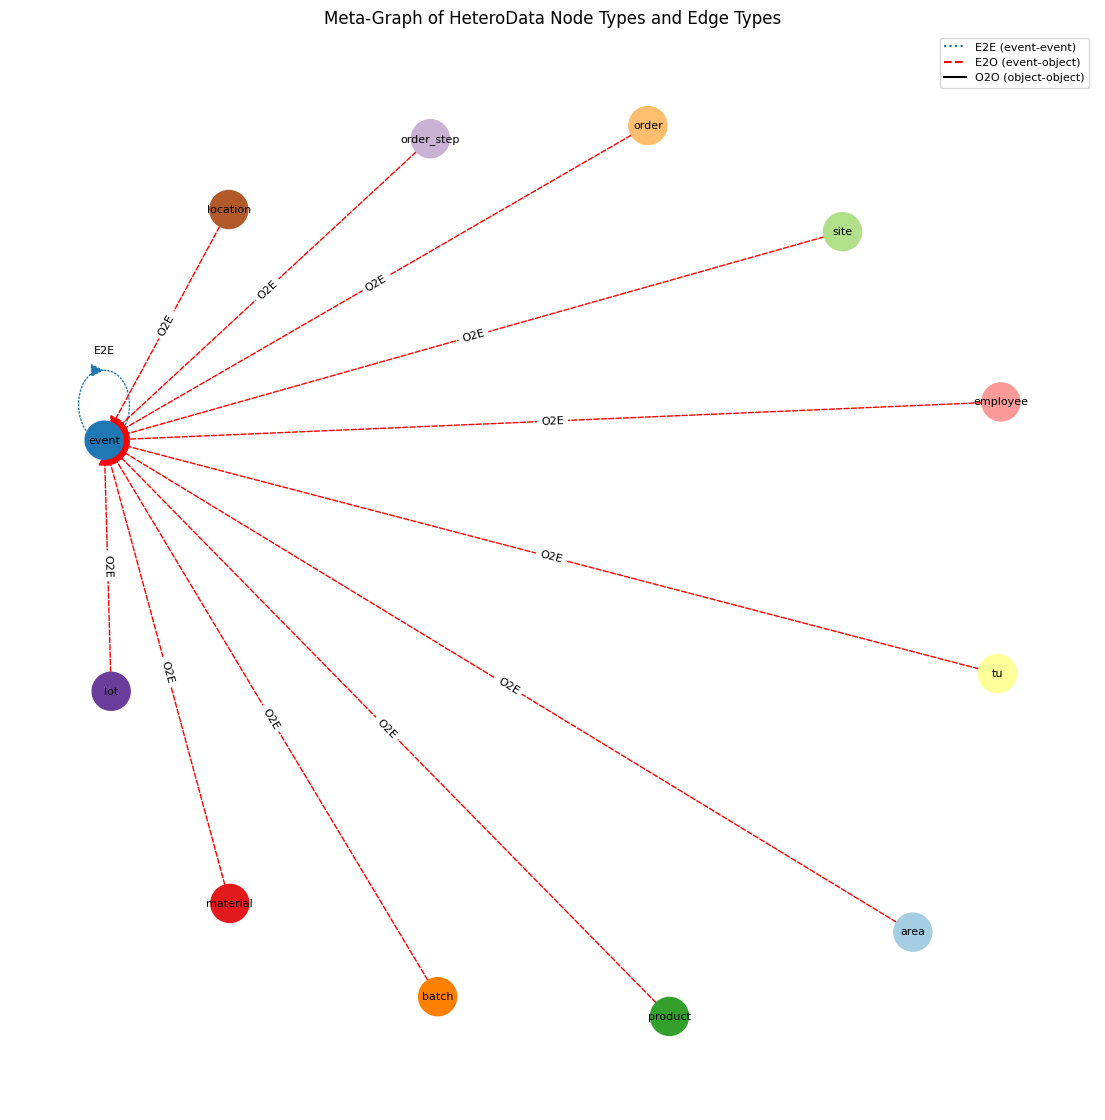

In [121]:
visualize_heterodata_meta_graph(data)

In [118]:
data.metadata()

(['event',
  'product',
  'material',
  'batch',
  'lot',
  'location',
  'area',
  'site',
  'employee',
  'order',
  'order_step',
  'tu'],
 [('lot', 'O2E', 'event'),
  ('material', 'O2E', 'event'),
  ('product', 'O2E', 'event'),
  ('area', 'O2E', 'event'),
  ('site', 'O2E', 'event'),
  ('order', 'O2E', 'event'),
  ('location', 'O2E', 'event'),
  ('order_step', 'O2E', 'event'),
  ('employee', 'O2E', 'event'),
  ('tu', 'O2E', 'event'),
  ('batch', 'O2E', 'event'),
  ('event', 'E2E', 'event')])